In [3]:
'''
Filename: Randoms

Goal: To read in dataset and correct for edge effects
'''

'\nFilename: Randoms\n\nGoal: To read in dataset and correct for edge effects\n'

In [5]:
import  astropy
import  pandas                  as      pd
import  pylab                   as      pl
import  numpy                   as      np
import  matplotlib.pyplot       as      plt
import  astropy.io.fits         as      fits
import  scipy
import  matplotlib as mpl

from    scipy                   import  optimize
from    scipy.integrate         import  quad
from    scipy.optimize          import  curve_fit
from    scipy.interpolate       import  interp1d, RegularGridInterpolator
from    scipy                   import  stats
from    astropy.table           import  Table, join, vstack, unique, setdiff
from    astropy.coordinates     import  SkyCoord, match_coordinates_sky
from    astropy                 import  units as u
from    astropy.io              import  ascii

from    tqdm                    import tqdm

In [4]:
from    astropy.cosmology       import  FlatLambdaCDM
# setting cosmological parameters
h = 1
cosmo = FlatLambdaCDM(H0=100*h * u.km / u.s / u.Mpc, Tcmb0=2.725 * u.K, Om0= 0.25) #0.3)

In [5]:
data = ascii.read('new_GAMA_dataset_ke_delta.csv', format='csv')

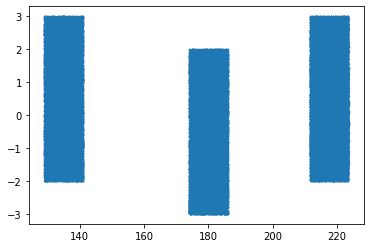

In [6]:
plt.scatter(data['TARGET_RA'], data['TARGET_DEC'], s=0.25)

In [10]:
tile_info = ascii.read('MXXL_tile_info.csv',format='csv')

In [11]:
tile_array = tile_info['TILEID']

In [13]:
min_z = min(data['Z'])
max_z = max(data['Z'])
print(min_z, max_z)
len(data)

0.00172 0.59134


In [14]:
import math
def find_nearest(array,value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return idx, array[idx-1]
    else:
        return idx, array[idx]

In [15]:
data1 = data
data1 = data1[data1['TARGET_RA'] < 150]
d1_ra_min, d1_ra_max = min(data1['TARGET_RA']), max(data1['TARGET_RA'])
d1_dec_min, d1_dec_max = min(data1['TARGET_DEC']), max(data1['TARGET_DEC'])

data2 = data
data2 = data2[data2['TARGET_RA'] > 150]
data2 = data2[data2['TARGET_RA'] < 200]
d2_ra_min, d2_ra_max = min(data2['TARGET_RA']), max(data2['TARGET_RA'])
d2_dec_min, d2_dec_max = min(data2['TARGET_DEC']), max(data2['TARGET_DEC'])

data3 = data
data3 = data3[data3['TARGET_RA'] > 200]
d3_ra_min, d3_ra_max = min(data3['TARGET_RA']), max(data3['TARGET_RA'])
d3_dec_min, d3_dec_max = min(data3['TARGET_DEC']), max(data3['TARGET_DEC'])

print(d1_ra_min, d1_ra_max)
print(d1_dec_min, d1_dec_max)
print(d2_ra_min, d2_ra_max)
print(d2_dec_min, d2_dec_max)
print(d3_ra_min, d3_ra_max)
print(d3_dec_min, d3_dec_max)

d_ra_min_array = [d1_ra_min, d2_ra_min, d3_ra_min]
d_ra_max_array = [d1_ra_max, d2_ra_max, d3_ra_max]
d_dec_min_array = [d1_dec_min, d2_dec_min, d3_dec_min]
d_dec_max_array = [d1_dec_max, d2_dec_max, d3_dec_max]

129.00007574 140.99960692
-1.99999154 2.9999192
174.00046468 185.99943836
-2.99990056 1.99991296
211.50030624 223.49985581
-1.99995686 2.99995944


In [16]:
'''
An adaptation for now so we're just looking at one field
'''
tile_info = tile_info[tile_info['TILEID'] == 0]
tile_array = tile_info['TILEID']

In [17]:
tile_info

TILEID,TILERA,TILEDEC
int32,float64,float64
0,150.14166562108926,2.1346107271019132


100%|██████████| 1751120/1751120 [12:06<00:00, 2411.35it/s]


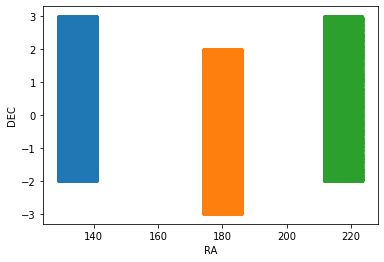

In [20]:
cart_x_all = []
cart_y_all = []
mock_z_all = []
bad_z_array = np.arange(0, 0.6, 0.001)
v_array = cosmo.comoving_volume(bad_z_array) * u.Mpc**-3
z_array_from_v = []

ra_all = []
dec_all = []
mock_tileid = []
rsf = 10

tile_array = [0, 0, 0]
for i in range(len(tile_array)):
    #datat = data[data['TILEID'] == tile_array[i]]
    #datat = data[data['ROSETTE'] == tile_array[i]]
    datat = data
    np.random.seed(10)
    
    cart_x = []
    cart_y = []
    '''
    while len(cart_x) < len(datat)*rsf:
        
        x = (np.random.random_sample() *2 - 1)
        y = (np.random.random_sample() *2 - 1)
        if x**2 + y**2 < 1:
            cart_x.append(x)
            cart_y.append(y)

            V_Vmax = np.random.random_sample()
            Vmax = h**3 * (cosmo.comoving_volume(max_z).value - cosmo.comoving_volume(min_z).value)
            V = V_Vmax * Vmax
            a = find_nearest(v_array, V)
            z_array_from_v.append(bad_z_array[a[0]])
            mock_tileid.append(i)
    '''
    x = np.random.uniform(low=d_ra_min_array[i], high=d_ra_max_array[i], size=(len(datat)*rsf,))
    y = np.random.uniform(low=d_dec_min_array[i], high=d_dec_max_array[i], size=(len(datat)*rsf,))
        
    for j in tqdm(range(len(x))):
        V_Vmax = np.random.random_sample()
        Vmax = h**3 * (cosmo.comoving_volume(max_z).value - cosmo.comoving_volume(min_z).value)
        V = V_Vmax * Vmax
        a = find_nearest(v_array, V)
        z_array_from_v.append(bad_z_array[a[0]])
        mock_tileid.append(i)
        
    ra = x
    dec = y
    
    '''
    cart_x_all.extend(cart_x)
    cart_y_all.extend(cart_y)
    
    
    cart_x1 = 1.75 * np.array(cart_x)
    cart_y1 = 1.75 * np.array(cart_y)

    #tile_ra = tile_info[tile_info['TILEID'] == tile_array[i]]['TILERA']
    #tile_dec = tile_info[tile_info['TILEID'] == tile_array[i]]['TILEDEC']
    tile_ra = tile_info['TILERA'][0]
    tile_dec = tile_info['TILEDEC'][0]
    
    ra  = cart_x1 / np.cos(np.radians(tile_dec)) + tile_ra
    dec = cart_y1 + tile_dec
    '''
    
    
    plt.scatter(ra, dec, s=0.25)
    plt.xlabel('RA')
    plt.ylabel('DEC')
    #plt.show()
    
    ra_all.extend(ra)
    dec_all.extend(dec)
    
    #hist, bins = np.histogram(datat['Z'], bins=2000)
    #bin_midpoints = bins[:-1] + np.diff(bins)/2
    #cdf = np.cumsum(hist)
    #cdf = cdf / cdf[-1]
    #values = np.random.rand(len(datat))
    #value_bins = np.searchsorted(cdf, values)
    #random_from_cdf = bin_midpoints[value_bins]
    #mock_redshift = random_from_cdf
    #mock_z_all.extend(mock_redshift)

In [21]:
print(len(ra), len(ra_all))

1751120 5253360


In [22]:
print(len(cart_x))
print(len(cart_x_all))
print(i)


0
0
2


In [23]:
len(z_array_from_v)

5253360

In [24]:
print(len(ra_all), len(dec_all), len(mock_z_all), len(mock_tileid))

5253360 5253360 0 5253360


In [25]:
randoms = Table([ra_all, dec_all, z_array_from_v, mock_tileid], names=('RA', 'DEC', 'Z', 'TILEID'))

In [2]:
randoms = ascii.read('randoms_newGAMA.csv', format='csv')

AttributeError: 'builtin_function_or_method' object has no attribute 'read'

In [21]:
'''
Same as before, but using randoms as centres
'''

'\nSame as before, but using randoms as centres\n'

(array([  1863.,  11868.,  31392.,  58830.,  96117., 145353., 198669.,
        265476., 335079., 428712., 509670., 613599., 724356., 844527.,
        987849.]),
 array([  11.98269208,  115.26376909,  218.5448461 ,  321.82592312,
         425.10700013,  528.38807714,  631.66915415,  734.95023116,
         838.23130817,  941.51238519, 1044.7934622 , 1148.07453921,
        1251.35561622, 1354.63669323, 1457.91777025, 1561.19884726]),
 <BarContainer object of 15 artists>)

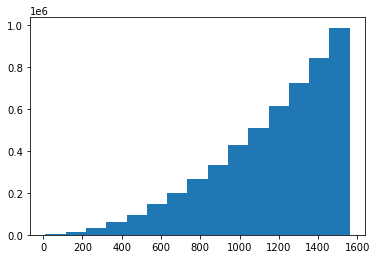

In [23]:
randoms['rc'] = cosmo.comoving_distance(randoms['Z'])
plt.hist(randoms['rc'], bins = 15)

In [28]:
len(randoms) / ((12*5*1) * cosmo.comoving_distance([max(randoms['Z'])]))

<Quantity [18.69418068] 1 / Mpc>

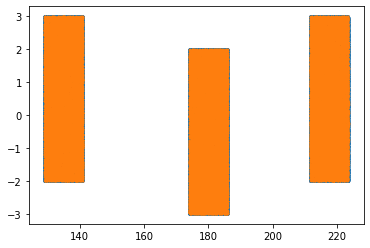

In [33]:
plt.scatter(randoms['RA'], randoms['DEC'], s=0.25)
plt.scatter(data['TARGET_RA'], data['TARGET_DEC'], s=0.25)

In [39]:
data = data[data['GFIELD'] == 12]

In [40]:
r = 8
data['D_L'] = cosmo.luminosity_distance(data['Z'])
randoms['D_L'] = cosmo.luminosity_distance(randoms['Z'])

#randoms['N_NEIGHBOUR'] = 0.0
#randoms['RHO'] = 0.0

data['N_RAND'] = 0.0
data['RHO_RAND'] = 0.0

# define DDPs here
#catalog = SkyCoord(data['TARGET_RA'][data['DDP1']=='True']*u.deg, data['TARGET_DEC'][data['DDP1']=='True']*u.deg, data[data['DDP1']=='True']['D_L'])

catalog = SkyCoord(randoms['RA']*u.deg, randoms['DEC']*u.deg, randoms['D_L'])

In [45]:
for i in tqdm(range(len(data))):
    if data['N_RAND'][i] == 0:
        c = SkyCoord(data['TARGET_RA'][i]*u.deg, data['TARGET_DEC'][i]*u.deg, distance=data['D_L'][i]*u.Mpc, frame="icrs")
        idx, d2d, d3d = c.match_to_catalog_3d(catalog,  nthneighbor=2)
        Ns = 0
        while (d3d <= (r/h)*u.Mpc):
            Ns += 1
            idx, d2d, d3d = c.match_to_catalog_3d(catalog,  nthneighbor=Ns+2)

        #if data[i]['DDP1'] == True:
        #    Ns = Ns + 1
        #    weight_array.append(data[i]['WEIGHT'])

        data['N_RAND'][i] = Ns

        #volume = 4/3 * np.pi * (r/h)**3
        #for j in range(Ns):
        #    data['RHO_RAND'][i] += 1.0 / volume 

100%|██████████| 61637/61637 [2:46:40<00:00,  6.16it/s]  


In [64]:
r = 8
data['D_L'] = cosmo.luminosity_distance(data['Z'])
randoms['D_L'] = cosmo.luminosity_distance(randoms['Z'])
randoms['N_RAND'] = 0.0
randoms['RHO'] = 0.0
catalog = SkyCoord(data['TARGET_RA'][data['DDP1']=='True']*u.deg, data['TARGET_DEC'][data['DDP1']=='True']*u.deg, data[data['DDP1']=='True']['D_L'])

In [73]:
randoms = randoms[randoms['RA'] < 150]

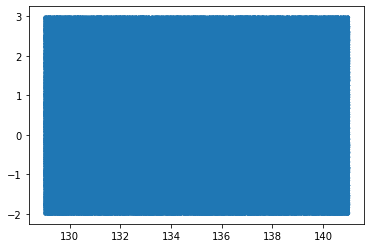

In [74]:
plt.scatter(randoms['RA'], randoms['DEC'], s=0.25)

In [75]:
'''
THE CORRECT CODE!!!
'''


volume = 4/3 * np.pi * (r/h)**3

    
for i in tqdm(range(len(randoms))):
    weight_array = []
    
    c = SkyCoord(randoms['RA'][i]*u.deg, randoms['DEC'][i]*u.deg, distance=randoms['D_L'][i]*u.Mpc, frame="icrs")
    idx, d2d, d3d = c.match_to_catalog_3d(catalog,  nthneighbor=2)
    
    Ns = 0
    while (d3d <= (r/h)*u.Mpc):
        Ns += 1
        idx, d2d, d3d = c.match_to_catalog_3d(catalog,  nthneighbor=Ns+2)
        #weight_array.append(data[idx]['WEIGHT'])

    #if data[i]['DDP1'] == True:
    #    Ns = Ns + 1
        #weight_array.append(data[i]['WEIGHT'])

    randoms['N_RAND'][i] = Ns
    
    #for j in range(Ns):
    #    data['RHO'][i] += weight_array[j]/volume 

100%|██████████| 1751120/1751120 [1:53:34<00:00, 256.96it/s]  


In [54]:
#ascii.write(data, 'new_random_data.csv', format='csv', fast_writer=False, overwrite=True)

In [47]:
data_storage = data

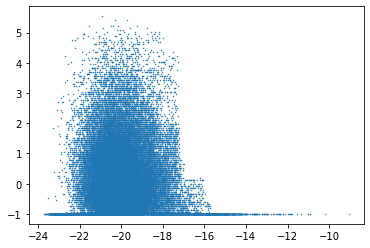

In [48]:
plt.scatter(data_storage['M_R'], data_storage['DELTA_8'], s=0.25)

In [52]:
ascii.write(data, 'new_random_data.csv', format='csv', fast_writer=False, overwrite=True)

In [ ]:
plt.hist(data['N_RAND'])

In [ ]:
#ascii.write(data, 'random_data_24112021.csv', fast_writer=False)

In [ ]:
data = ascii.read('random_data.csv', format='csv')

In [ ]:
testing = data[data['N_RAND'] != 0]

In [ ]:
fig, ax = plt.subplots(1,1)
c = ax.scatter(testing['TARGET_RA'], testing['TARGET_DEC'], c=testing['N_RAND'], s=0.25, cmap='plasma')
ax.set_xlabel('RA')
ax.set_ylabel('DEC')
cbar = plt.colorbar(c)
cbar.set_label(r'$N_s$')

In [ ]:
fig, ax = plt.subplots(1,1)
c = ax.scatter(testing['TARGET_RA'], testing['TARGET_DEC'], c=testing['N_RAND'] - testing['N_EXPECT_DDP1'], s=0.25, cmap='plasma')
ax.set_xlabel('RA')
ax.set_ylabel('DEC')
cbar = plt.colorbar(c)
cbar.set_label(r'$N_s - N_{s, expected}$')

In [1]:
'''
read in and test random exclusion here:
'''

data = ascii.read('random_data_23112021.csv', format='csv')

AttributeError: 'builtin_function_or_method' object has no attribute 'read'

In [2]:
data

NameError: name 'data' is not defined

In [183]:
volume = (4/3) * np.pi * (8/h)**3 

In [184]:
data['RHO_RAND'] = data['N_RAND'] / volume 

In [185]:
DDP1_z_min, DDP1_z_max = 0.04777225169874262, 0.2186483841036385
DDP2_z_min, DDP2_z_max = 0.027497430525990296, 0.16024849909437924
DDP3_z_min, DDP3_z_max = 0.017382928933400838, 0.08694869187788506

try:
    #num_of_tiles = len(np.unique(data['TILEID']))
    num_of_tiles = len(np.unique(data['ROSETTE']))
except:
    num_of_tiles = 16
dia = 3 # diameter of tile, CHECK THIS!!!!!!!
deg_sq = (dia/2)**2 * np.pi * num_of_tiles

deg_sq = 12*5*3

sky_fraction = deg_sq / 41253 # total sq deg. on sky

mean_DDP1_w = np.mean(data[data['DDP1'] == 'True']['WEIGHT'])
DDP1_vol = h**3 * (cosmo.comoving_volume(DDP1_z_max).value - cosmo.comoving_volume(DDP1_z_min).value) * sky_fraction
#rho_bar = len(data[data['DDP1'] == True]) / DDP1_vol
rho_bar = (len(data[data['DDP1'] == 'True']) * mean_DDP1_w) / DDP1_vol
print(rho_bar)

mean_DDP2_w = np.mean(data[data['DDP2'] == 'True']['WEIGHT'])
DDP2_vol = h**3 * (cosmo.comoving_volume(DDP2_z_max).value - cosmo.comoving_volume(DDP2_z_min).value) * sky_fraction
#rho_bar = len(data[data['DDP1'] == True]) / DDP1_vol
rho_bar_2 = (len(data[data['DDP2'] == 'True']) * mean_DDP2_w) / DDP2_vol
print(rho_bar_2)

mean_DDP3_w = np.mean(data[data['DDP3'] == 'True']['WEIGHT'])
DDP3_vol = h**3 * (cosmo.comoving_volume(DDP3_z_max).value - cosmo.comoving_volume(DDP3_z_min).value) * sky_fraction
#rho_bar = len(data[data['DDP1'] == True]) / DDP1_vol
rho_bar_3 = (len(data[data['DDP3'] == 'True']) * mean_DDP3_w) / DDP3_vol
print(rho_bar_3)

0.010553151661842994
0.015615546380757194
0.030755966861029688


In [186]:
len(data[data['DDP1'] == 'True'])

29553

In [187]:
data['N_EXPECT_DDP1'] = volume * (rho_bar)
data['N_EXPECT_DDP2'] = volume * (rho_bar_2)
data['N_EXPECT_DDP3'] = volume * (rho_bar_3)

In [189]:
data['DDP1_CF'] = data['N_RAND'] / data['N_EXPECT_DDP1']  
data['DDP2_CF'] = data['N_RAND'] / data['N_EXPECT_DDP2']  
data['DDP3_CF'] = data['N_RAND'] / data['N_EXPECT_DDP3']  

In [191]:
ascii.write(data, 'random_data_23112021.csv', format='csv', fast_writer=False, overwrite='True')

(array([  762.,  6521., 22611., 23894., 20031., 15734.,  5421.,  1715.,
          242.,    51.]),
 array([0.        , 0.23859042, 0.47718085, 0.71577127, 0.9543617 ,
        1.19295212, 1.43154255, 1.67013297, 1.9087234 , 2.14731382,
        2.38590425]),
 <a list of 10 Patch objects>)

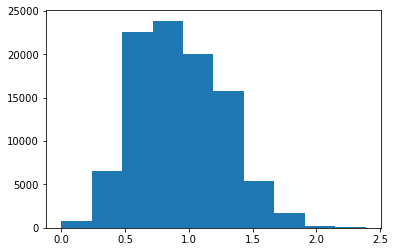

In [209]:
plt.hist(data['DDP1_CF'])

In [210]:
data_t = data

In [203]:
data_t['DELTA_8_CF'] = ((data_t['DELTA_8']+1) / data_t['DDP1_CF']) - 1

<ipython-input-203-32fc8114c430>:1: RuntimeWarning: invalid value encountered in true_divide
  data['DELTA_8_CF'] = ((data['DELTA_8']+1) / data['DDP1_CF']) - 1


In [ ]:
for i in range(len(data_t)):
    if data_t['DDP1_CF'][i] > 1:
        data_t['DDP1_CF'][i] = 1
    elif data_t[]

In [217]:
data_t['DDP1_CF']

0.6627511793829002
0.7953014152594803
1.0604018870126404
1.1045852989715004
0.44183411958860014
0.5302009435063202
0.0
0.8394848272183403
1.0604018870126404
1.0604018870126404
1.0604018870126404


In [225]:
data_t['DDP1_CF'][data_t['DDP1_CF'] >= 1] = 1

In [226]:
data_t['DELETE'] = False
for i in range(len(data_t)):
    if data_t['DDP1_CF'][i] < 0.5:
        data_t['DELETE'][i] = True

(array([ 6738.,  4125.,  4459.,  4610.,  4797.,  4885.,  4871.,  4749.,
         4592., 43194.]),
 array([0.53020094, 0.57718085, 0.62416075, 0.67114066, 0.71812057,
        0.76510047, 0.81208038, 0.85906028, 0.90604019, 0.95302009,
        1.        ]),
 <a list of 10 Patch objects>)

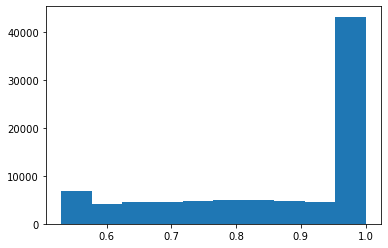

In [227]:
plt.hist(data_t[data_t['DELETE'] == False]['DDP1_CF'])

In [228]:
DDP1_Mr_min = -21.8
DDP1_Mr_max = -20.1

DDP2_Mr_min = -20.6
DDP2_Mr_max = -19.3

DDP3_Mr_min = -19.6
DDP3_Mr_max = -17.8

mr_limit = 19.8
mr_bright_limit = 14

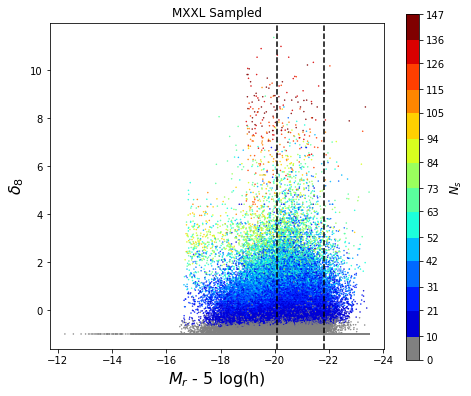

In [229]:

'''
without selection cut
'''

fig, ax = plt.subplots(1, 1, figsize=(6, 6))  # setup the plot

cmap = plt.cm.jet  # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# force the first color entry to be grey
cmaplist[0] = (.5, .5, .5, 1.0)

# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)

# define the bins and normalize

#bounds = np.linspace(0, int(max(data['N_NEIGHBOUR'])), (int(max(data['N_NEIGHBOUR'])+1)))
bounds = np.linspace(0, int(max(data['N_NEIGHBOUR'])), (int(max(data['N_NEIGHBOUR'])/10+1)), dtype=int)

norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

# make the scatter
#scat = ax.scatter(x, y, c=tag, s=np.random.randint(100, 500, 20),
#                  cmap=cmap, norm=norm)

ax.scatter(data['M_R'], data['DELTA_8_CF'], c=data['N_NEIGHBOUR'], s=0.25, cmap=cmap, norm=norm)
#ax.set_ylim(-1.5, 8)

# create a second axes for the colorbar
ax2 = fig.add_axes([0.95, 0.1, 0.03, 0.8])
cb = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm, spacing='proportional', ticks=bounds, boundaries=bounds, format='%1i')

#ax.set_title('MXXL Unsampled')
ax.set_title('MXXL Sampled')
ax.axvline(DDP1_Mr_min, color='black', ls='--')
ax.axvline(DDP1_Mr_max, color='black', ls='--')
#ax.axhline(-1, color='r', ls='--')
ax.invert_xaxis()
ax.set_xlabel(r'$M_r$ - 5 log(h)', fontsize=16)
ax.set_ylabel(r'$\delta_8$', fontsize=16)

ax2.set_ylabel(r'$N_s$', size=12)
plt.show()

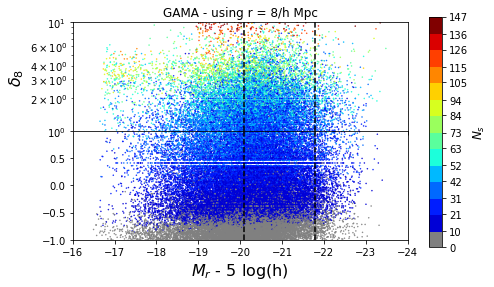

In [230]:

'''
without selection cut
'''
fig, axs = plt.subplots(2,1, sharex=True)
plt.subplots_adjust(wspace=0, hspace=0)


cmap = plt.cm.jet  # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# force the first color entry to be grey
cmaplist[0] = (.5, .5, .5, 1.0)

# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)

# define the bins and normalize

#bounds = np.linspace(0, int(max(data['N_NEIGHBOUR'])), (int(max(data['N_NEIGHBOUR'])+1)))
bounds = np.linspace(0, int(max(data['N_NEIGHBOUR'])), (int(max(data['N_NEIGHBOUR'])/10+1)), dtype=int)

norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

ax2 = fig.add_axes([0.95, 0.1, 0.03, 0.8])
cb = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm, spacing='proportional', ticks=bounds, boundaries=bounds, format='%1i')


axs[0].scatter(data['M_R'], data['DELTA_8_CF']*1.17, c=data['N_NEIGHBOUR'], s=0.25, cmap=cmap, norm=norm)
axs[1].scatter(data['M_R'], data['DELTA_8_CF']*1.17, c=data['N_NEIGHBOUR'], s=0.25, cmap=cmap, norm=norm)

axs[0].set_xlim(-24, -16)

axs[0].set_ylim(1, 10)
axs[1].set_ylim(-1, 0.999)
axs[0].set_yscale('log')
axs[0].set_yticks([1, 10])

axs[0].set_title('GAMA - using r = 8/h Mpc')
axs[0].axvline(DDP1_Mr_min, color='black', ls='--')
axs[0].axvline(DDP1_Mr_max, color='black', ls='--')
axs[1].axvline(DDP1_Mr_min, color='black', ls='--')
axs[1].axvline(DDP1_Mr_max, color='black', ls='--')

axs[0].invert_xaxis()
axs[1].set_xlabel(r'$M_r$ - 5 log(h)', fontsize=16)
axs[0].set_ylabel(r'$\delta_8$', fontsize=16)
ax2.set_ylabel(r'$N_s$', size=12)
plt.show()

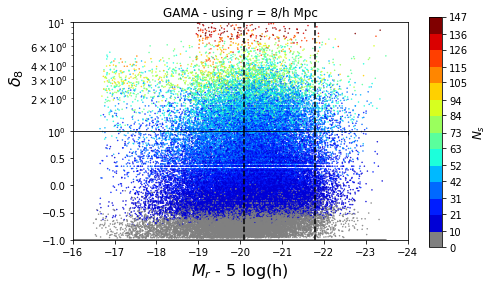

In [234]:
'''
with selection cut
'''
data_t = data_t[data_t['DELETE'] == False]

fig, axs = plt.subplots(2,1, sharex=True)
plt.subplots_adjust(wspace=0, hspace=0)


cmap = plt.cm.jet  # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# force the first color entry to be grey
cmaplist[0] = (.5, .5, .5, 1.0)

# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)

# define the bins and normalize

#bounds = np.linspace(0, int(max(data['N_NEIGHBOUR'])), (int(max(data['N_NEIGHBOUR'])+1)))
bounds = np.linspace(0, int(max(data['N_NEIGHBOUR'])), (int(max(data['N_NEIGHBOUR'])/10+1)), dtype=int)

norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

ax2 = fig.add_axes([0.95, 0.1, 0.03, 0.8])
cb = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm, spacing='proportional', ticks=bounds, boundaries=bounds, format='%1i')


axs[0].scatter(data_t['M_R'], data_t['DELTA_8_CF'], c=data_t['N_NEIGHBOUR'], s=0.25, cmap=cmap, norm=norm)
axs[1].scatter(data_t['M_R'], data_t['DELTA_8_CF'], c=data_t['N_NEIGHBOUR'], s=0.25, cmap=cmap, norm=norm)

axs[0].set_xlim(-24, -16)

axs[0].set_ylim(1, 10)
axs[1].set_ylim(-1, 0.999)
axs[0].set_yscale('log')
axs[0].set_yticks([1, 10])

axs[0].set_title('GAMA - using r = 8/h Mpc')
axs[0].axvline(DDP1_Mr_min, color='black', ls='--')
axs[0].axvline(DDP1_Mr_max, color='black', ls='--')
axs[1].axvline(DDP1_Mr_min, color='black', ls='--')
axs[1].axvline(DDP1_Mr_max, color='black', ls='--')

axs[0].invert_xaxis()
axs[1].set_xlabel(r'$M_r$ - 5 log(h)', fontsize=16)
axs[0].set_ylabel(r'$\delta_8$', fontsize=16)
ax2.set_ylabel(r'$N_s$', size=12)
plt.show()

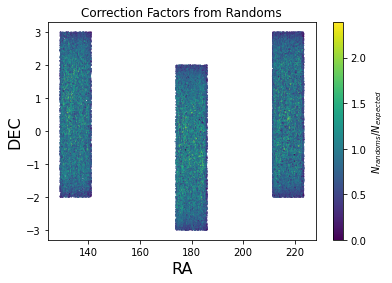

In [216]:
plt.scatter(data['TARGET_RA'], data['TARGET_DEC'], s=0.25, c=data['DDP1_CF'])
cbar = plt.colorbar()
cbar.set_label(r'$N_{randoms} / N_{expected}$')
plt.xlabel('RA', fontsize=16)
plt.ylabel('DEC', fontsize=16)
plt.title('Correction Factors from Randoms')
plt.show()

In [ ]:
plt.scatter(data[data['FIELD_ID'] == 9]['TARGET_RA'], data[data['FIELD_ID'] == 9]['TARGET_DEC'], s=0.25, c=data[data['FIELD_ID'] == 9]['DDP1_CF'])
cbar = plt.colorbar()
cbar.set_label(r'$N_{randoms} / N_{expected}$')
plt.xlabel('RA', fontsize=16)
plt.ylabel('DEC', fontsize=16)
plt.title('Correction Factors from Randoms')
plt.show()

In [ ]:
data_t = data
data_t = data_t[data_t['FIELD_ID'] == 9]
data_t = data_t[data_t['Z'] > 0.1]
data_t = data_t[data_t['Z'] < 0.105]
plt.scatter(data_t['TARGET_RA'], data_t['TARGET_DEC'], s=0.25, c=data_t['DDP1_CF'])


In [ ]:
print(num_of_tiles)

In [ ]:
plt.hist(randoms['DELTA_8'])

KeyError: 'N_NEIGHBOUR'

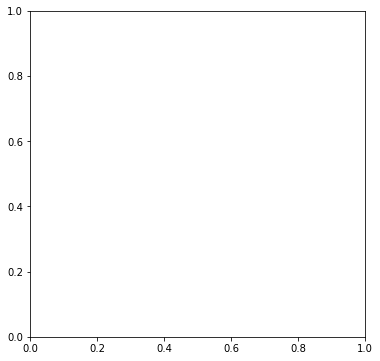

In [197]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))  # setup the plot

tag = np.random.randint(0, 20, 20)
tag[10:12] = 0  # make sure there are some 0 values to show up as grey

cmap = plt.cm.jet  # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# force the first color entry to be grey
cmaplist[0] = (.5, .5, .5, 1.0)

# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)

# define the bins and normalize

#bounds = np.linspace(0, int(max(data['N_NEIGHBOUR'])), (int(max(data['N_NEIGHBOUR'])+1)))
bounds = np.linspace(0, int(max(randoms['N_NEIGHBOUR'])), (int(max(randoms['N_NEIGHBOUR'])/10+1)), dtype=int)

norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

# make the scatter
#scat = ax.scatter(x, y, c=tag, s=np.random.randint(100, 500, 20),
#                  cmap=cmap, norm=norm)

ax.scatter(randoms['M_R'], randoms['DELTA_8'], c=randoms['N_NEIGHBOUR'], s=0.25, cmap=cmap, norm=norm)
#ax.set_ylim(-1.5, 8)

# create a second axes for the colorbar
ax2 = fig.add_axes([0.95, 0.1, 0.03, 0.8])
cb = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm, spacing='proportional', ticks=bounds, boundaries=bounds, format='%1i')

#ax.set_title('MXXL Unsampled')
ax.set_title('MXXL Sampled')
ax.axvline(DDP1_Mr_min, color='black', ls='--')
ax.axvline(DDP1_Mr_max, color='black', ls='--')
#ax.axhline(-1, color='r', ls='--')
ax.invert_xaxis()
ax.set_xlabel(r'$M_r$ - 5 log(h)', fontsize=16)
ax.set_ylabel(r'$\delta_8$', fontsize=16)

ax2.set_ylabel(r'$N_s$', size=12)
plt.show()

In [ ]:
plt.scatter(data['TARGET_RA'], data['TARGET_DEC'], s=0.25)
plt.scatter(randoms['RA'], randoms['DEC'], s=0.25)
plt.show()